# Data Pre-processing
- Import libs: pandas, numpy, sklearn, matplotlib

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Read data from file
 - Read file 'VNPT_TH.csv' and display data type

In [2]:
data = pd.read_csv("../data/data.csv")
data.dtypes

TVOC     float64
TEMP     float64
HUM      float64
PM01     float64
CO2      float64
NH3      float64
LIGHT    float64
AQI      float64
PM25     float64
PM10     float64
CO       float64
O3       float64
SO2      float64
time      object
dtype: object

- Display 10 first records

In [3]:
data.head(10)

TVOC  TEMP   HUM  PM01    CO2  NH3  LIGHT   AQI  PM25  PM10   CO    O3  \
0  77.0  27.7  72.9  14.0  909.0  5.1    0.0  61.3  61.3  15.7  0.0  18.5   
1  67.0  27.7  73.2  14.0  845.0  4.9    0.0  61.3  61.3  15.7  0.0  18.5   
2  67.0  27.7  73.1  14.0  845.0  5.1    0.0  61.3  61.3  15.7  0.0  18.5   
3  66.0  27.7  73.1  14.0  835.0  5.2    0.0  61.3  61.3  15.7  0.0  18.5   
4  57.0  27.7  73.3  14.0  777.5  4.9    0.0  61.3  61.3  15.7  0.0  18.5   
5  52.5  27.7  73.4  14.0  748.0  4.9    0.0  61.3  61.3  15.7  0.0  19.4   
6  47.0  27.7  73.4  14.0  712.0  5.4    0.0  61.3  61.3  15.7  0.0  18.5   
7  47.0  27.7  73.5  14.0  712.0  5.2    0.0  61.3  61.3  15.7  0.0  18.9   
8  44.0  27.7  73.6  14.0  691.0  5.2    0.0  61.3  61.3  15.7  0.0  19.4   
9  41.5  27.7  73.7  14.0  678.5  4.7    0.0  61.3  61.3  15.7  0.0  18.5   

   SO2                 time  
0  7.1  2019-05-31 17:00:00  
1  7.1  2019-05-31 17:10:00  
2  7.1  2019-05-31 17:20:00  
3  7.1  2019-05-31 17:30:00  
4  7.1  2019-05-31 17:40:00  
5  7.1  2019-05-31 17:50:00  
6  7.1  2019-05-31 18:00:00  
7  7.1  2019-05-31 18:10:00  
8  7.1  2019-05-31 18:20:00  
9  7.1  2019-05-31 18:30:00

## Remove NaN and outliers

In [4]:
date_time = pd.to_datetime(data['time'])
data['time'] = date_time
data = data.dropna(axis=0)
data = data.drop(['SO2', 'CO', 'NH3', 'O3', 'AQI', 'PM01', 'TVOC'], axis=1)
data = data.drop(data[data.LIGHT >= 1000].index)

data.describe()

TEMP           HUM           CO2         LIGHT          PM25  \
count  15594.000000  15594.000000  15594.000000  15594.000000  15594.000000   
mean      28.371752     60.874856   1249.957118     25.940779     47.809613   
min       20.700000     35.900000    400.000000      0.000000      0.000000   
25%       27.600000     55.900000    541.000000      0.000000     33.300000   
50%       28.600000     61.200000    755.000000      2.000000     50.000000   
75%       29.400000     67.000000   1224.000000     15.000000     61.300000   
max       33.100000     77.400000   7992.000000    315.000000    121.900000   
std        1.879867      7.735902   1451.796138     63.715778     19.953644   

               PM10                           time  
count  15594.000000                          15594  
mean      12.315814  2019-09-13 02:30:38.137745152  
min        0.000000            2019-05-31 17:00:00  
25%        7.400000            2019-08-18 01:22:30  
50%       12.000000            2019-09-20 21:35:00  
75%       15.700000            2019-10-18 02:27:30  
max       48.100000            2019-11-14 07:40:00  
std        6.457094                            NaN

## Generate features and labels
- List of all features:
    - **f1**: Month
    - **f2**: Weekend
    - **f3**: Hour
    - **f4**: Current PM25 AQI value
    - **f5**: Current CO2 concentration
    - **f6**: Current TVOC concentration
    - **f7**: Current temperature
    - **f8**: Current humidity
    - **f9**: Current illuminance
    - **f10 → f34**: PM25 AQI value from 1 to 24 hour ago
    - **f35**: maximum PM25 AQI value in last 24 hours
    - **f36**: minimum PM25 AQI value in last 24 hours
    - **f37**: average PM25 AQI value in last 24 hours
    - **f38**: maximum temperature in last 24 hours
    - **f39**: minimum temperature in last 24 hours
    - **f40**: average temperature in last 24 hours
    - **f41**: maximum humidity in last 24 hours
    - **f42**: minimum humidity in last 24 hours
    - **f43**: average humidity in last 24 hours
- Label: Next PM25 AQI value


### Create <i>Month</i>, <i>Day of week</i>, <i>Hour</i> features from time column.

In [5]:
time_idx = pd.DatetimeIndex(data.time)
data = data.groupby([time_idx.month, time_idx.day, time_idx.dayofweek, time_idx.hour]).mean(numeric_only=True)
data.index.names = ["Month", "Day", "Weekend", "Hour"]
data.index = data.index.droplevel(1)
# data.head(30)

### Generate features f10 → f34

In [6]:
PM25_cols = []
TEMP_cols = []
HUM_cols = []

for i in range(1, 25):
    col = 'PM25P' + str(i)
    PM25_cols.append(col)
    data[col] = data['PM25'].shift(periods=i)
    
    col = 'TEMPP' + str(i)
    TEMP_cols.append(col)
    data[col] = data['TEMP'].shift(periods=i)
    
    col = 'HUMP' + str(i)
    HUM_cols.append(col)
    data[col] = data['HUM'].shift(periods=i)
    
data["MAXPM25"] = data[PM25_cols].max(axis=1)
data["MINPM25"] = data[PM25_cols].min(axis=1)
data["AVGPM25"] = data[PM25_cols].mean(axis=1)

data["MAXTEMP"] = data[TEMP_cols].max(axis=1)
data["MINTEMP"] = data[TEMP_cols].min(axis=1)
data["AVGTEMP"] = data[TEMP_cols].mean(axis=1)

data["MAXHUM"] = data[HUM_cols].max(axis=1)
data["MINHUM"] = data[HUM_cols].min(axis=1)
data["AVGHUM"] = data[HUM_cols].mean(axis=1)

data = data.drop(TEMP_cols, axis=1)
data = data.drop(HUM_cols, axis=1)

### Generate labels

In [7]:
data['Label'] = data['PM25'].shift(periods=-1)


### Remove rows having NaN value

In [8]:
data = data.dropna(axis=0)
columns = data.index.names
columns = np.append(columns, data.columns.values[:-1])
date_time_values = np.asmatrix([list(item) for item in data.index.values])
data = np.append(date_time_values, data.to_numpy(), axis=1)
data[:, 1] = np.where(data[:, 1] < 5, 0, 1)

bin_season = np.where(data[:, 0] <= 3, [0, 0], np.where(data[:, 0] <= 6, [0, 1], np.where(data[:, 0] <= 9, [1, 0], np.where(data[:, 0] <= 12, [1, 1], 0))))
data = np.delete(data, 0, 1)
data = np.append(bin_season, data, axis=1)
data
np.savetxt("VNPT_TH_DATA.csv", data, delimiter=",")

# Run and evaluate algorithms

## Prepare data and matplotlib plot


- **y**: label is last column

In [9]:
y = data[:,-1].reshape(-1, 1)
X = data[:,:-1]

- Train set (75%) and test set (25%) are chosen randomly from data 

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

- Prepare matplotlib plot to display model evaluation

In [11]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = [16, 10]

## Multi-layer Perceptron

C:\Users\hungn\Documents\hanoi-air-quality-forecast\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1625: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP regression score: 0.8318


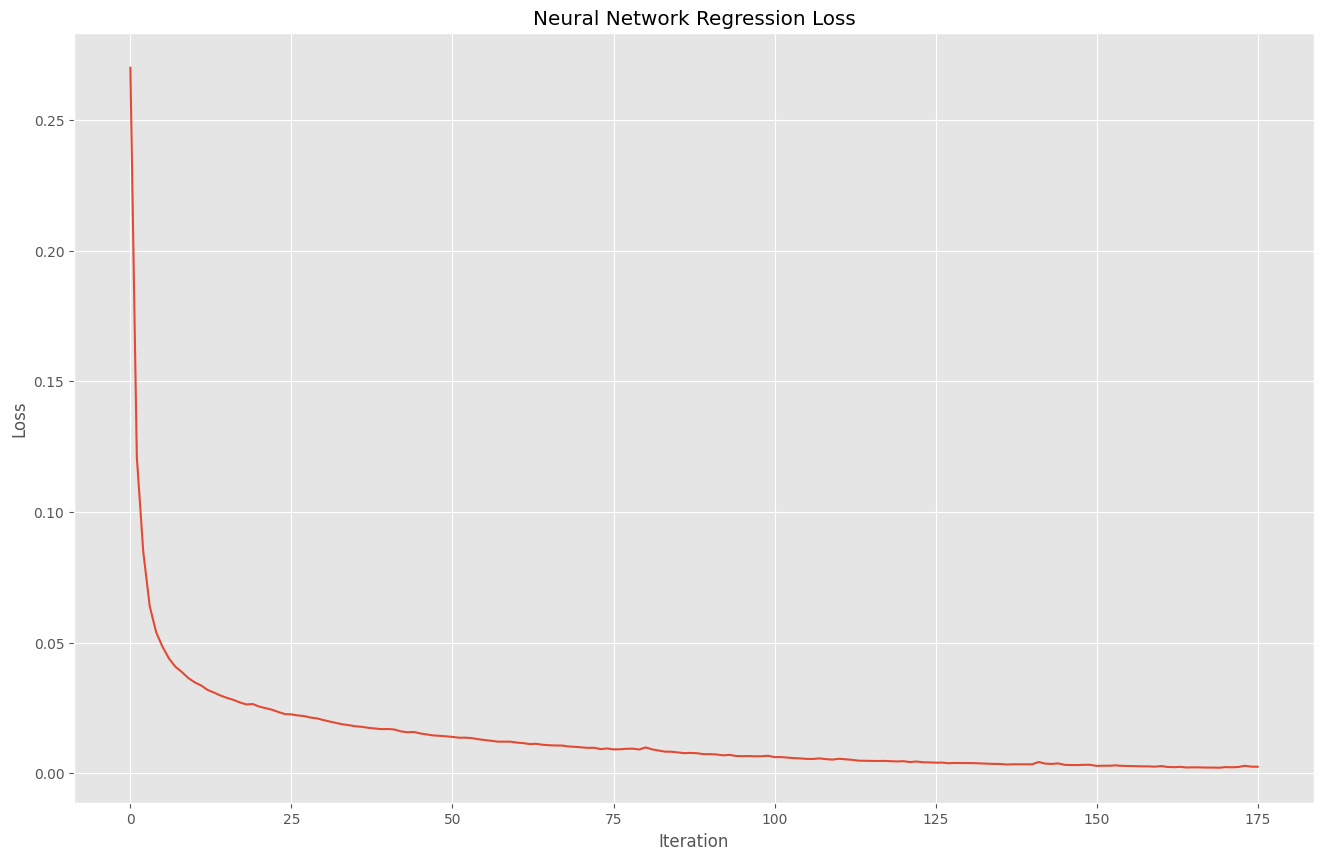

In [12]:
mlp = MLPRegressor(hidden_layer_sizes=(90, 90,))
# mlp = MLPRegression(hidden_layer_sizes=(256,), max_iter=1000, learning_rate=5e-4, tol=1e-6, batch_size=192)
mlp.fit(X_train, y_train)

mlp_score = mlp.score(X_test, y_test)
print("MLP regression score: {:.4f}".format(mlp_score))

plt.plot(mlp.loss_curve_)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Neural Network Regression Loss')
plt.show()

nnr_pred = mlp.predict(X_test)

Root mean squared error: 0.4012
Mean absolute error: 0.2462
R-squared: 0.8318


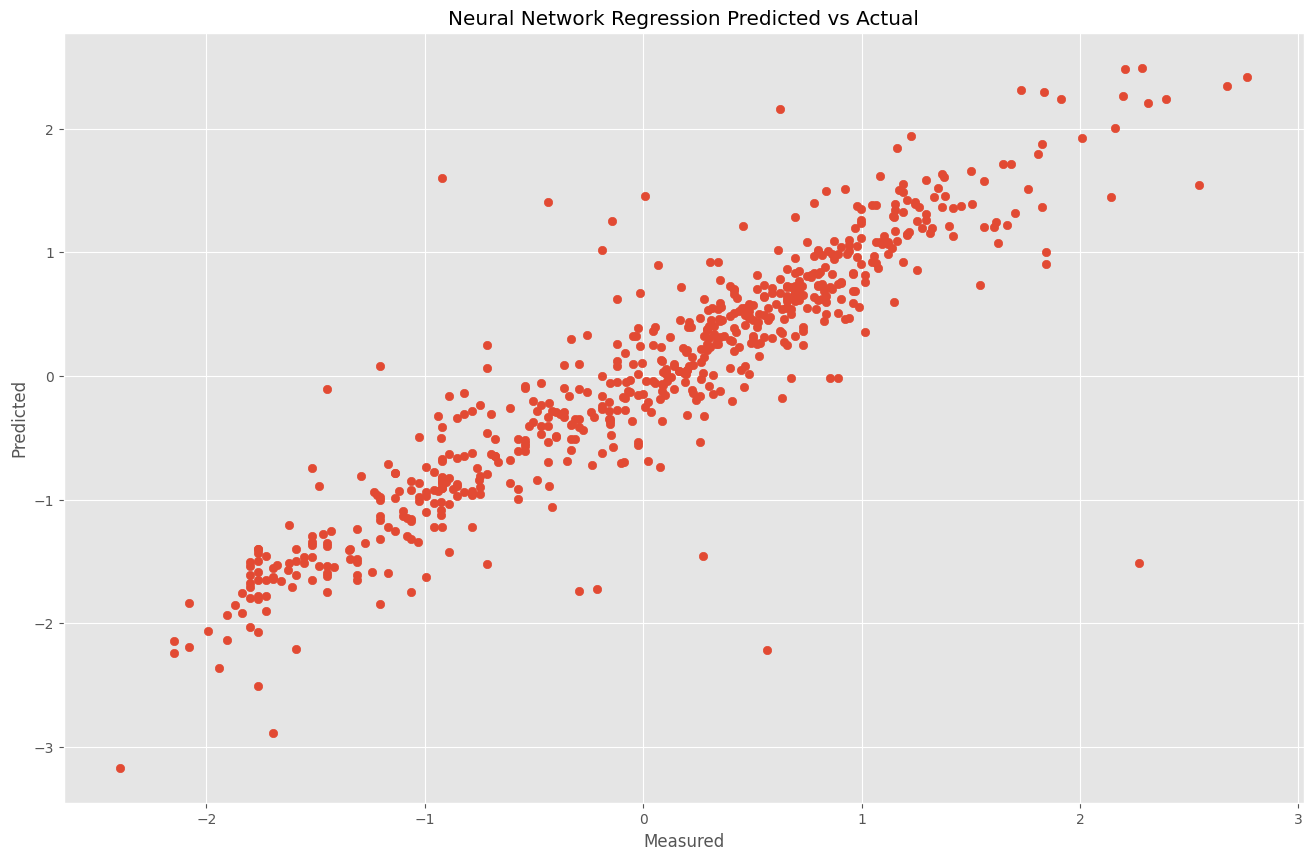

In [13]:
# The mean squared error
print("Root mean squared error: {:.4f}".format(np.sqrt(mean_squared_error(y_test, nnr_pred))))

# The absolute squared error
print("Mean absolute error: {:.4f}".format(mean_absolute_error(y_test, nnr_pred)))

# Explained variance score: 1 is perfect prediction
print("R-squared: {:.4f}".format(r2_score(y_test, nnr_pred)))


plt.scatter(y_test, nnr_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Neural Network Regression Predicted vs Actual')
plt.show()

## Decision Forest Regression

In [14]:
rf_regression = RandomForestRegressor(n_estimators=200, random_state=1234)
rf_regression.fit(X_train, y_train)

rf_score = rf_regression.score(X_test, y_test)
print("Random forest regression score: {:.4f}".format(rf_score))

rf_pred = rf_regression.predict(X_test)

C:\Users\hungn\Documents\hanoi-air-quality-forecast\venv\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Random forest regression score: 0.8723


In [15]:
# The mean squared error
print("Root mean squared error: {:.4f}".format(np.sqrt(mean_squared_error(y_test, rf_pred))))

# The absolute squared error
print("Mean absolute error: {:.4f}".format(mean_absolute_error(y_test, rf_pred)))

# Explained variance score: 1 is perfect prediction
print("R-squared: {:.4f}".format(r2_score(y_test, rf_pred)))

Root mean squared error: 0.3495
Mean absolute error: 0.2068
R-squared: 0.8723


- Display how important features are

['Month' 'Weekend' 'Hour' 'TEMP' 'HUM' 'CO2' 'LIGHT' 'PM25' 'PM10'
 'PM25P1' 'PM25P2' 'PM25P3' 'PM25P4' 'PM25P5' 'PM25P6' 'PM25P7' 'PM25P8'
 'PM25P9' 'PM25P10' 'PM25P11' 'PM25P12' 'PM25P13' 'PM25P14' 'PM25P15'
 'PM25P16' 'PM25P17' 'PM25P18' 'PM25P19' 'PM25P20' 'PM25P21' 'PM25P22'
 'PM25P23' 'PM25P24' 'MAXPM25' 'MINPM25' 'AVGPM25' 'MAXTEMP' 'MINTEMP'
 'AVGTEMP' 'MAXHUM' 'MINHUM' 'AVGHUM']


IndexError: index 42 is out of bounds for axis 0 with size 42

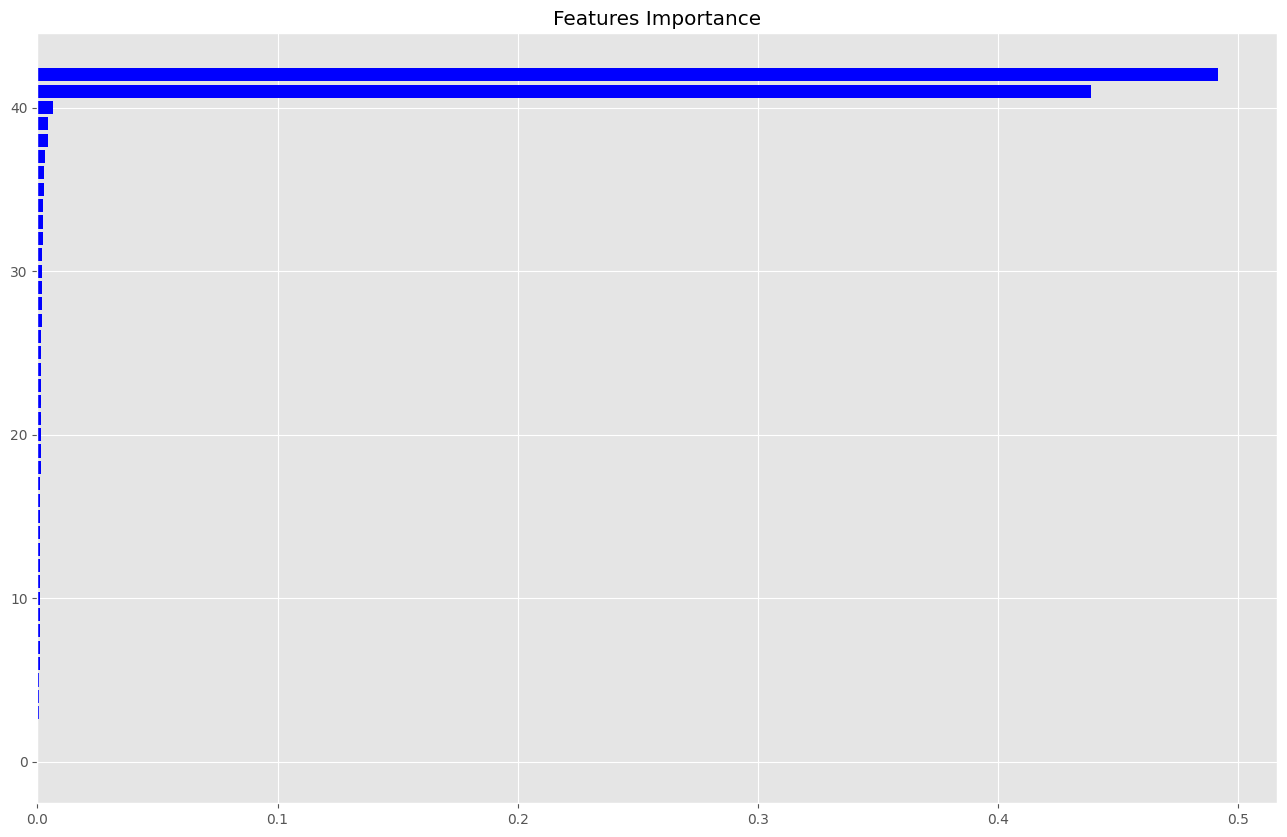

In [16]:
print(columns)
features = columns
importance = rf_regression.feature_importances_
indices = np.argsort(importance)

plt.title('Features Importance')
plt.barh(range(len(indices)), importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

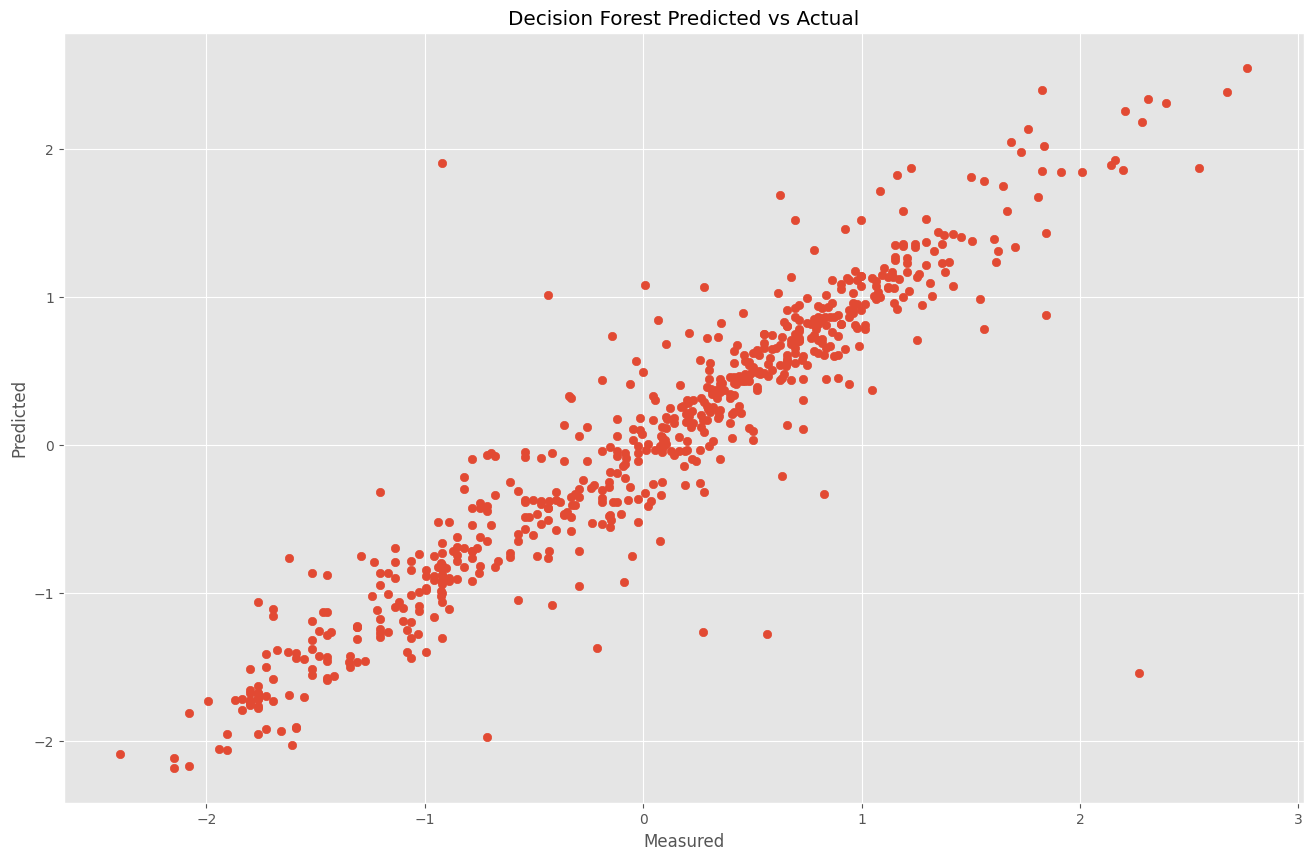

In [17]:
plt.scatter(y_test, rf_pred)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Decision Forest Predicted vs Actual')
plt.show()